# Environment

In [1]:
import re
import torch
import model
from pathlib import Path
from random import randint
import pytorch_lightning as pl
from IPython.display import Audio
from helpers.path_utils import get_base_dir
from helpers.plot import compare_audios, plot_wavelet_spectrogram, plot_audio_fft, plot_model_result

# Seconds to split each recording
# it will be the size of input and output (secs)
CHUNK_SECS = 2

# Sample rate of both recordings
sample_rate = 4000

# Lower and upper bounds for the % of noise vs the original input
NOISE_VOL_RANGE = (0.4, 0.8)

# The upper bound the recording (input, output or both)
# is going to be filtered with Butterworth Filter (in Hz)
CUTOFF_FREQ = 270

# How strict the Lowpass Filter is filtering undesired frequencies
FILTER_ORDER = 4

# Params for training
BATCH_SIZE = 10
TRAIN_RATIO = 0.80
VAL_RATIO = 0.15

base_dir = get_base_dir()
TENSORS_DIR = base_dir.joinpath("data", "model", "original")
NOISE_DIR = base_dir.joinpath("data", "hospital-ambient-noise", "original")

# Instance Dataset

In [2]:
transformations = model.Compose([
    model.AddHospitalNoise(
        noise_dir=NOISE_DIR,
        noise_volume_range=NOISE_VOL_RANGE,
        sample_rate_target=sample_rate
        ),
    model.LowpassFilter(
        sample_rate=sample_rate,
        cutoff_freq=CUTOFF_FREQ,
        order=FILTER_ORDER
        ),
    model.Normalize()
])

cora_dataset = model.CoraTechDataset(TENSORS_DIR, CHUNK_SECS, transform=transformations)
n_samples = len(cora_dataset)

print(f"Number of samples: {n_samples}")

Number of samples: 392


# Compare heartbeats

In [3]:
choosen_one = randint(0, n_samples - 1)
print(f"#{choosen_one + 1} / {n_samples}")

mobile_sample, stethos_sample = cora_dataset[choosen_one]

print(
    "mobile shape, mean and std: ",
    mobile_sample.shape,
    mobile_sample.mean(),
    mobile_sample.std(),
)
print(
    "stethos shape, mean and std: ",
    stethos_sample.shape,
    stethos_sample.mean(),
    stethos_sample.std(),
)

#346 / 392
mobile shape, mean and std:  torch.Size([8000]) tensor(1.4305e-09) tensor(1.)
stethos shape, mean and std:  torch.Size([8000]) tensor(-3.7104e-09) tensor(1.)


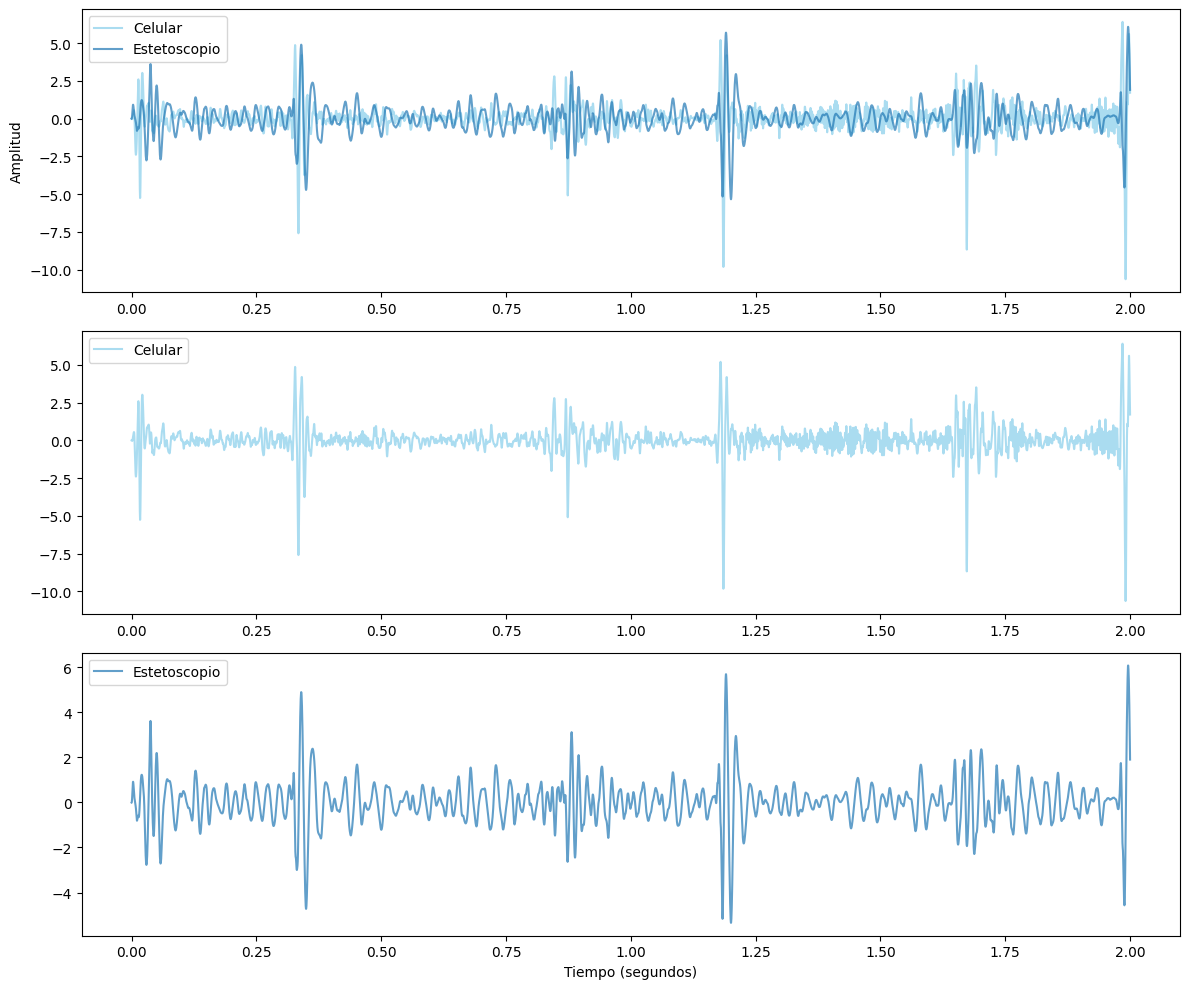

Celular:


Estetoscopio:


In [4]:
compare_audios(
    first_audio=mobile_sample,
    first_title="Celular",
    second_audio=stethos_sample,
    second_title="Estetoscopio",
    sample_rate=sample_rate
)
print("Celular:")
display(Audio(mobile_sample, rate=sample_rate, autoplay=True))
print("Estetoscopio:")
display(Audio(stethos_sample, rate=sample_rate, autoplay=True))

## Mobile recording

### Without transformations

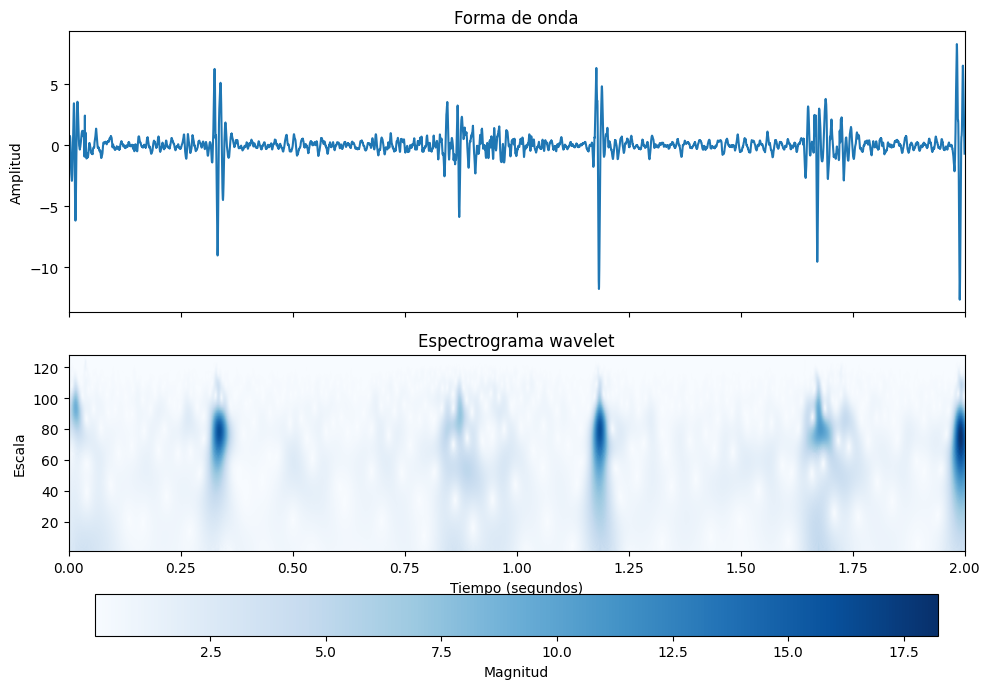

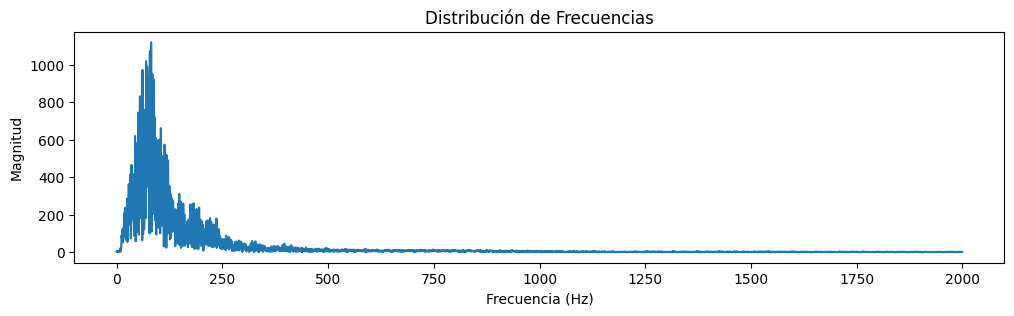

In [6]:
without_noise = model.CoraTechDataset(TENSORS_DIR, CHUNK_SECS)
mobile_without_transform, _ = without_noise[choosen_one]

plot_wavelet_spectrogram(mobile_without_transform.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(mobile_without_transform.numpy(), sample_rate)
Audio(mobile_without_transform, rate=sample_rate, autoplay=True)

### With transformations for training

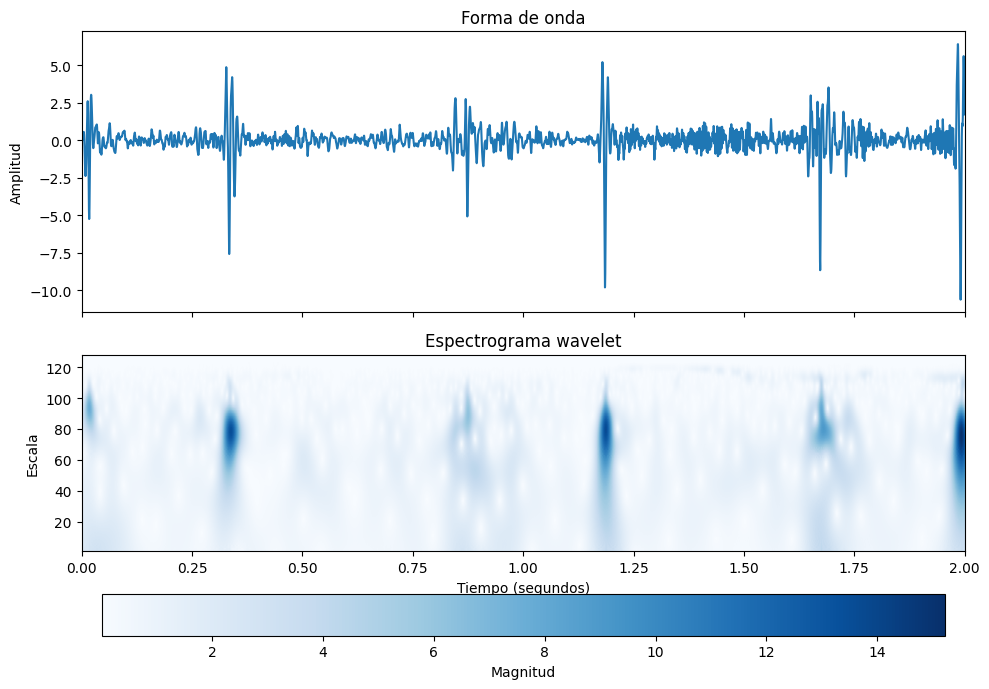

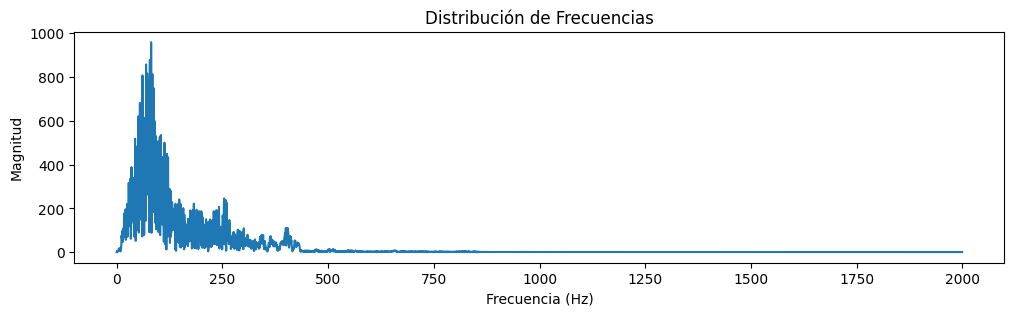

In [7]:
plot_wavelet_spectrogram(mobile_sample.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(mobile_sample.numpy(), sample_rate)
Audio(mobile_sample, rate=sample_rate, autoplay=True)

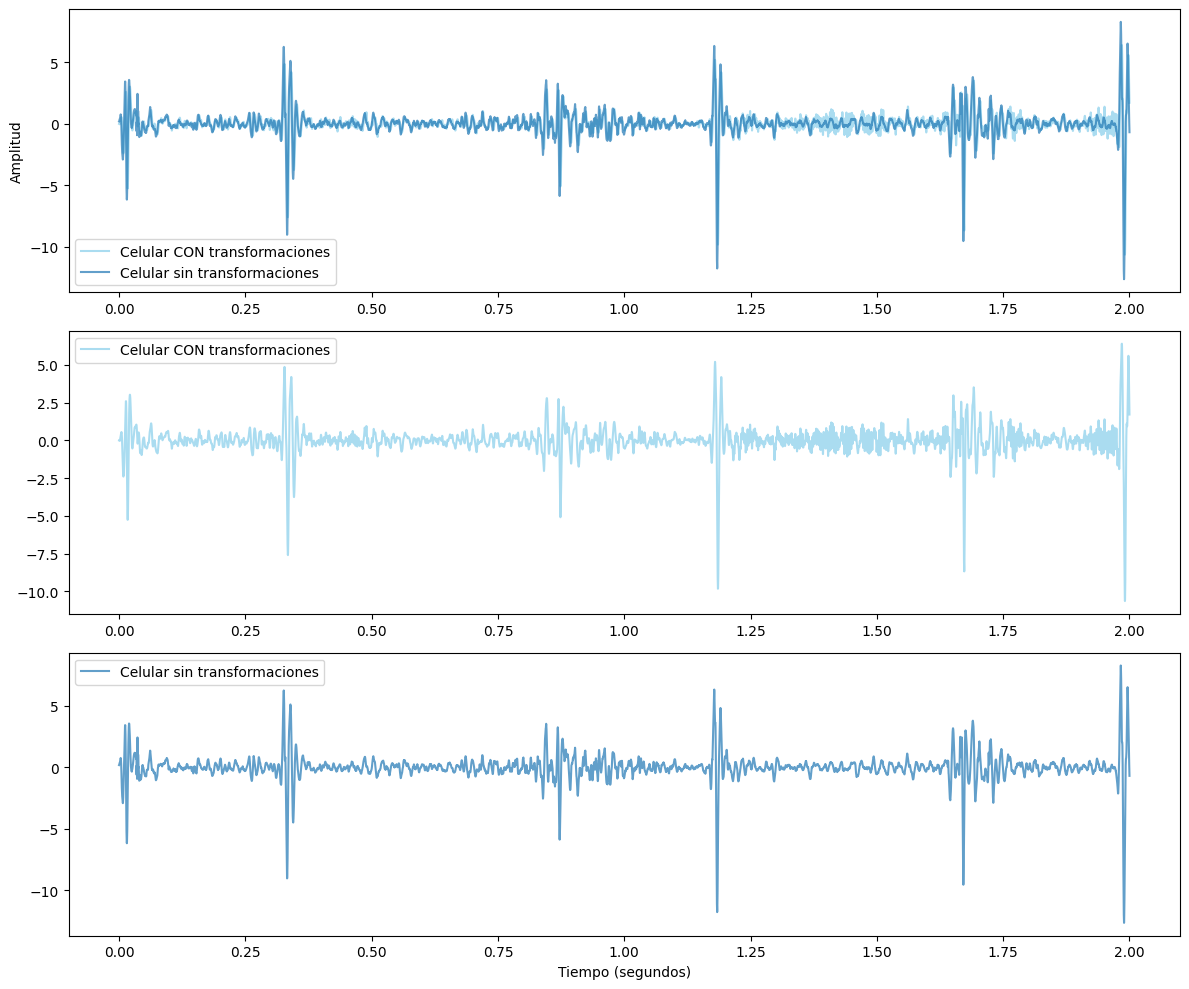

Celular sin transformaciones:


Celular CON transformaciones:


Estetoscopio:


In [8]:
compare_audios(
    first_audio=mobile_sample,
    first_title="Celular CON transformaciones",
    second_audio=mobile_without_transform,
    second_title="Celular sin transformaciones",
    sample_rate=sample_rate
)

print("Celular sin transformaciones:")
display(Audio(mobile_without_transform, rate=sample_rate, autoplay=True))
print("Celular CON transformaciones:")
display(Audio(mobile_sample, rate=sample_rate, autoplay=True))
print("Estetoscopio:")
display(Audio(stethos_sample, rate=sample_rate, autoplay=True))


## Stethoscope recording

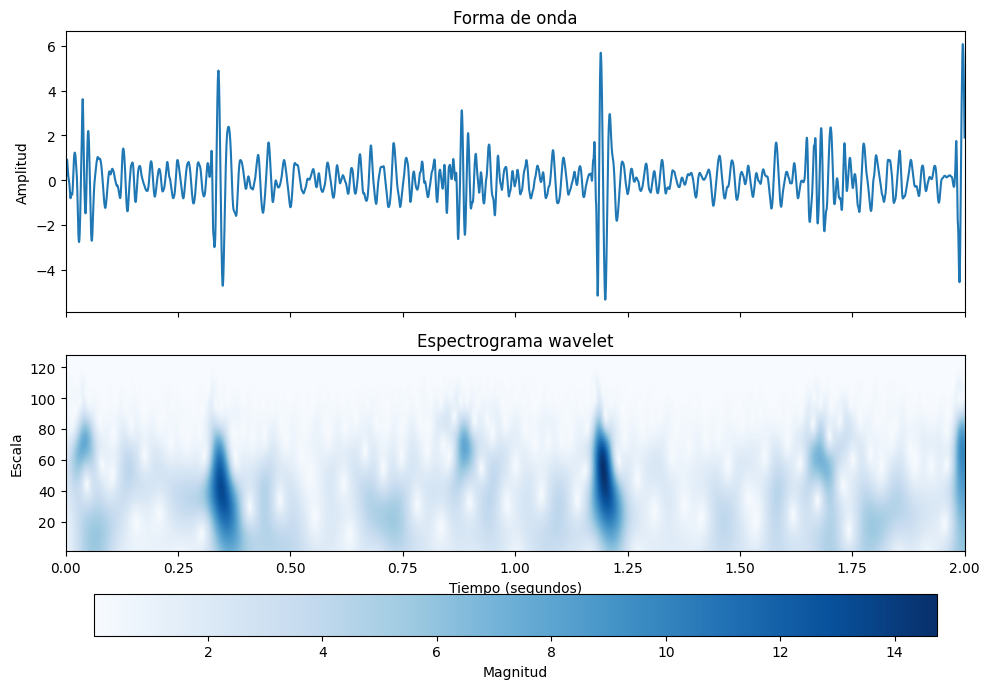

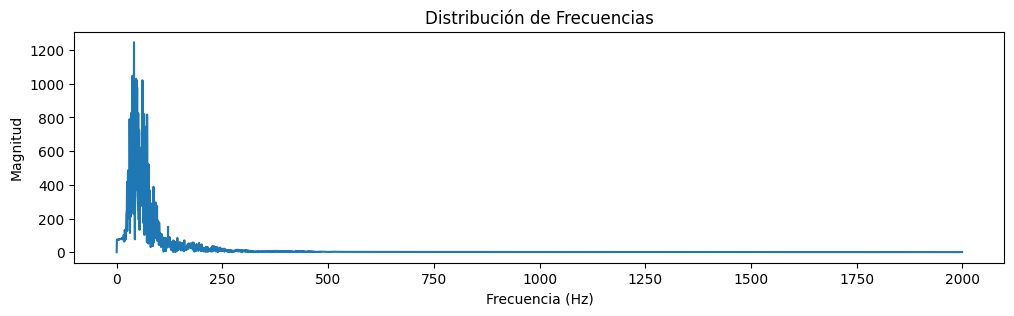

In [9]:
plot_wavelet_spectrogram(stethos_sample.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(stethos_sample.numpy(), sample_rate)
Audio(stethos_sample, rate=sample_rate, autoplay=True)

# Train, validation and test split

In [10]:
train_size = int(TRAIN_RATIO * len(cora_dataset))
val_size = int(VAL_RATIO * len(cora_dataset))
test_size = len(cora_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    cora_dataset, [train_size, val_size, test_size]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples:\t\t{train_size} = {len(train_dataloader)} batches")
print(f"Validation samples:\t{val_size} = {len(val_dataloader)} batches")
print(f"Test samples:\t\t{test_size} = {len(test_dataloader)} batches")
print(f"Total samples:\t\t{train_size + val_size + test_size} = {len(cora_dataset) // BATCH_SIZE} batches")

Batch size: 10
Train samples:		313 = 32 batches
Validation samples:	58 = 6 batches
Test samples:		21 = 3 batches
Total samples:		392 = 39 batches


# Callbacks

In [11]:
input_secs = mobile_sample.shape[-1] // sample_rate

checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath=f"checkpoints/input-{input_secs}s",
    filename="model-{val_loss:.4f}-{epoch:02d}",
    save_top_k=1,
    mode="min",
)

early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

callbacks = [checkpoint, early_stopping, lr_monitor]

# Train!

In [12]:
input_size = cora_dataset[0][0].shape[-1]
trained_model = model.CoraTechModel(input_size)

logger = pl.loggers.tensorboard.TensorBoardLogger("logs/", name="coratech_model")

trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, logger=logger)
trainer.fit(trained_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\coratech\notebooks\model\checkpoints\input-2s exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | fc1     | Linear      | 2.0 M  | train
1 | bn1     | BatchNorm1d | 512    | train
2 | fc2     | Linear      | 32.9 K | train
3 | bn2     | BatchNorm1d | 256    | train
4 | fc3     | Linear      | 33.0 K | train
5 | bn3     | BatchNorm1d | 512    | train
6 | fc4     | Linear      | 2.1 M  | train
7 | relu    | ReLU        | 0      | train
8 | dropout | Dropout     | 0      | train
------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.686    T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\efrai\.virtualenvs\coratech-fbR9J1lO\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Predict

## Best model

In [13]:
directory = Path('checkpoints').joinpath(f"input-{input_secs}s")
pattern = r'model-val_loss=([\d\.]+)-epoch=\d+\.ckpt'
val_loss_values = {}

for model_path in directory.iterdir():
    if model_path.is_file():
        match = re.match(pattern, model_path.name)
        if match:
            val_loss = float(match.group(1))
            val_loss_values[model_path] = val_loss

if val_loss_values:
    best_model = min(val_loss_values, key=val_loss_values.get)
    print(f"The {input_secs}s-input model with the lowest validation loss is:\n{best_model.name}\nwith a loss of {val_loss_values[best_model]}")
else:
    print("No models matching the specified pattern were found.")

The 2s-input model with the lowest validation loss is:
model-val_loss=0.5773-epoch=11.ckpt
with a loss of 0.5773


In [14]:
model_to_pred = model.CoraTechModel(input_size)

model_to_pred.load_state_dict(torch.load(best_model)['state_dict'])
model_to_pred.eval()

CoraTechModel(
  (fc1): Linear(in_features=8000, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=8000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

# Loss in validation set

In [15]:
total_loss = 0.0
num_samples = 0

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch
        predictions = model_to_pred(inputs)
        batch_loss = torch.nn.L1Loss()(predictions, targets)
        total_loss += batch_loss.item()
        num_samples += len(inputs)

mse_loss = total_loss / num_samples
print(f'MAE Loss in test set: {mse_loss:.4f}')

MAE Loss in test set: 0.0793


# Result!

#19 / 21


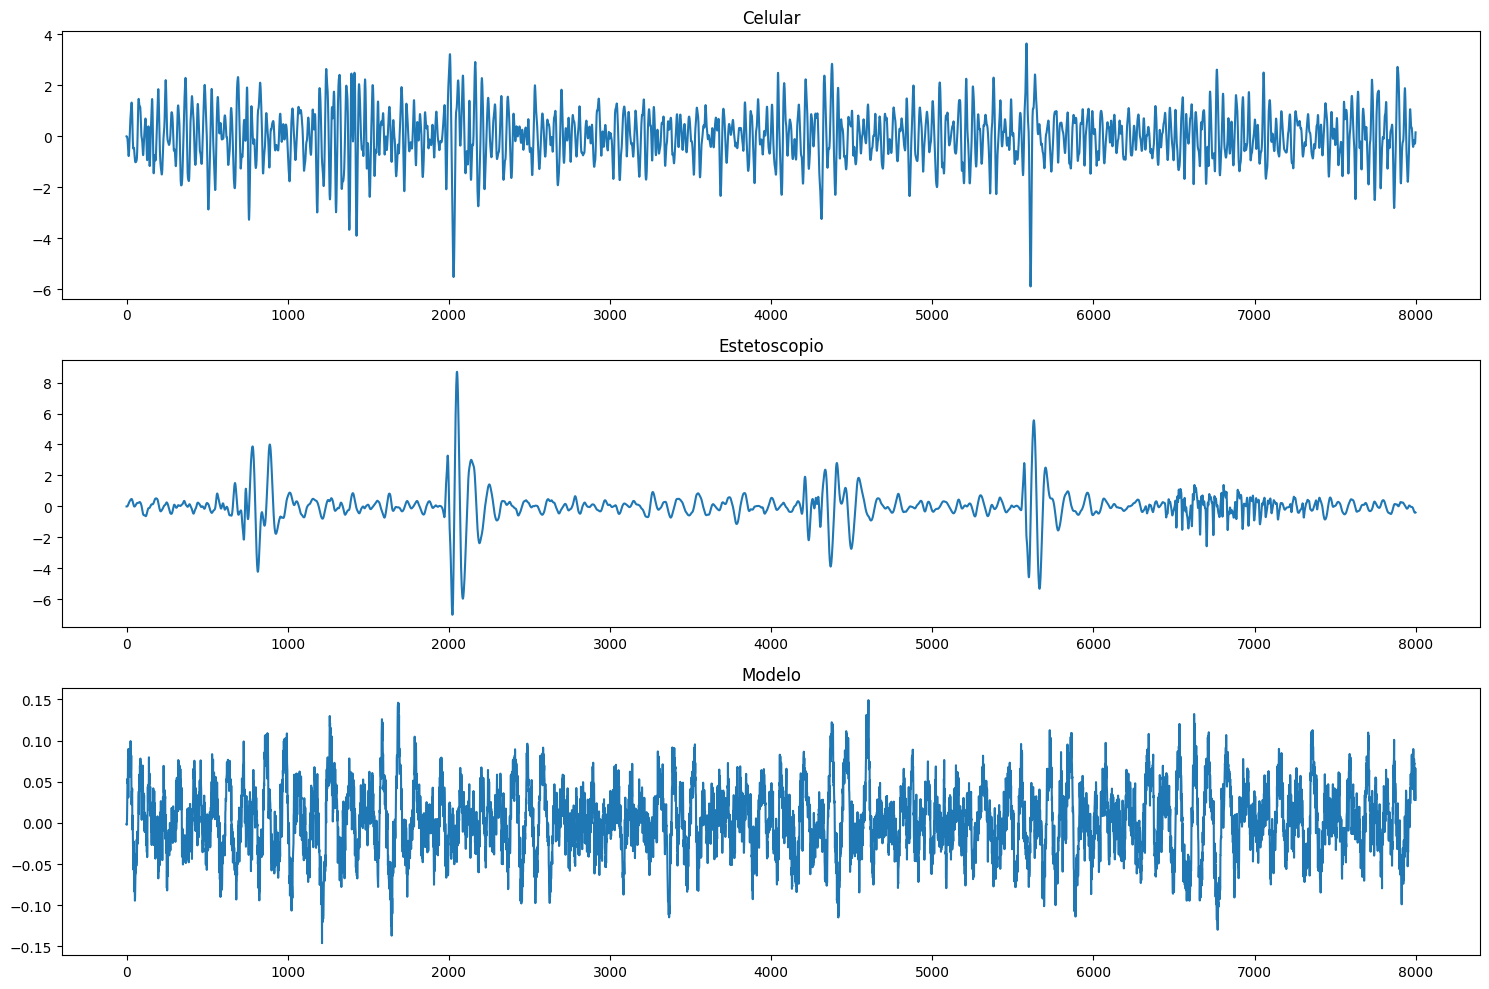

Celular:


Estetoscopio:


Modelo:


In [19]:
test_data_length = len(test_dataset)
choosen_one_test = randint(0, test_data_length - 1)

print(f"#{choosen_one_test} / {test_data_length}")

model_result = plot_model_result(model_to_pred, test_dataset, choosen_one_test)

mobile_test_sample, stethos_test_sample = test_dataset[choosen_one_test]

print("Celular:")
display(Audio(mobile_test_sample, rate=sample_rate, autoplay=True))
print("Estetoscopio:")
display(Audio(stethos_test_sample, rate=sample_rate, autoplay=True))
print("Modelo:")
display(Audio(model_result, rate=sample_rate, autoplay=True))

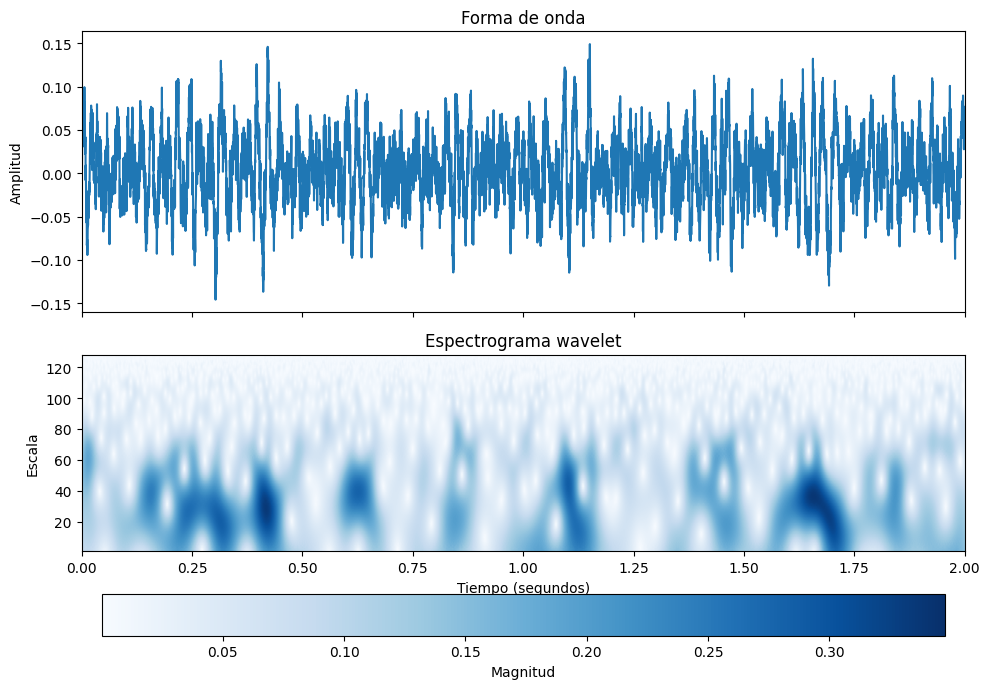

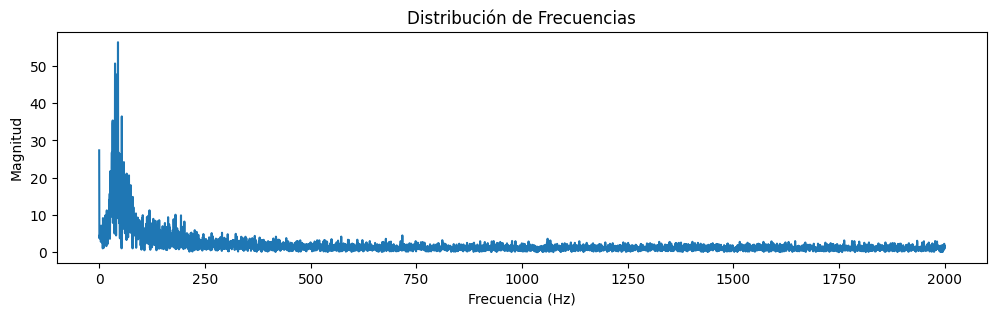

In [20]:
plot_wavelet_spectrogram(model_result.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(model_result.numpy(), sample_rate)
display(Audio(model_result, rate=sample_rate, autoplay=True))